In [1]:
import os

os.chdir("../../..")
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from modular_splicing.width_experiments.distance_between_motifs import (
    nearest_neigboring_motifs_distances,
    nearest_neighbor_motifs_differences_table,
)
from modular_splicing.width_experiments.flank_robustness import (
    compute_all_flank_robustnesses,
    genome_data,
    random_data,
    models_to_analyze,
)
from modular_splicing.utils.plots import regress
from modular_splicing.utils.statistics import bootstrap

In [4]:
models = models_to_analyze()

In [5]:
results_genome = compute_all_flank_robustnesses(
    models, genome_data, list(range(11, 1 + 21))
)
results_random = compute_all_flank_robustnesses(
    models, random_data, [11]
)  # list(range(11, 1 + 21)))

In [6]:
def plot_motif_robustness(table, sort_amount, label):
    table = table.sort_values(sort_amount)[::-1]
    plt.figure(figsize=(8.2, 3.4), dpi=200, tight_layout=True)
    for i in sorted(table)[::-1]:
        plt.plot(table[i] * 100, linestyle=" ", marker=".", label=i, color="black" if i == 21 else None)
    plt.xticks(rotation=90)
    plt.tick_params(axis="x", labelsize=7)
    plt.legend()
    plt.ylabel(label)
    plt.xlabel(f"Motif [sorted by {sort_amount}]")
    plt.grid()
    plt.show()

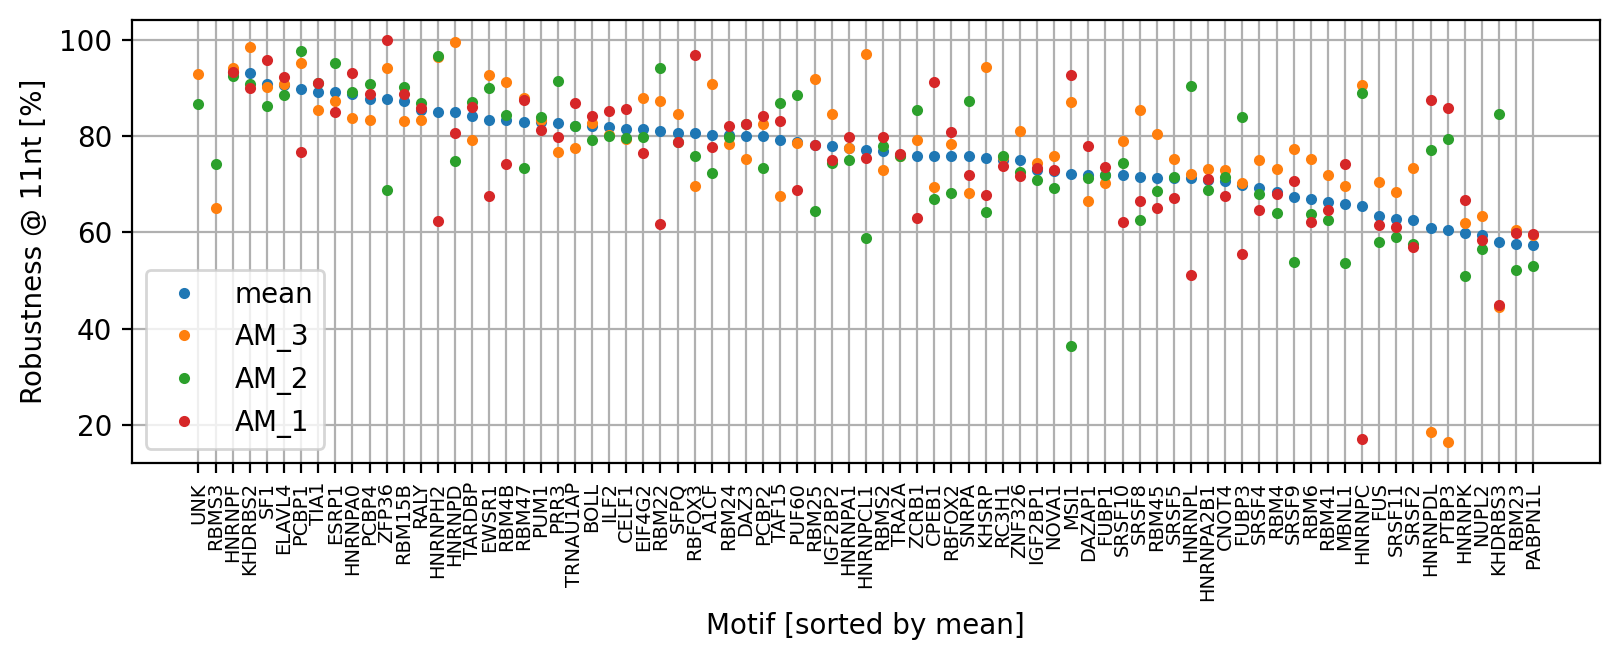

In [7]:
at_11 = pd.DataFrame(
    {k: results_genome[k][11].apply(lambda x: x[0]) for k in results_genome}
)
plot_motif_robustness(at_11, "mean", "Robustness @ 11nt [%]")

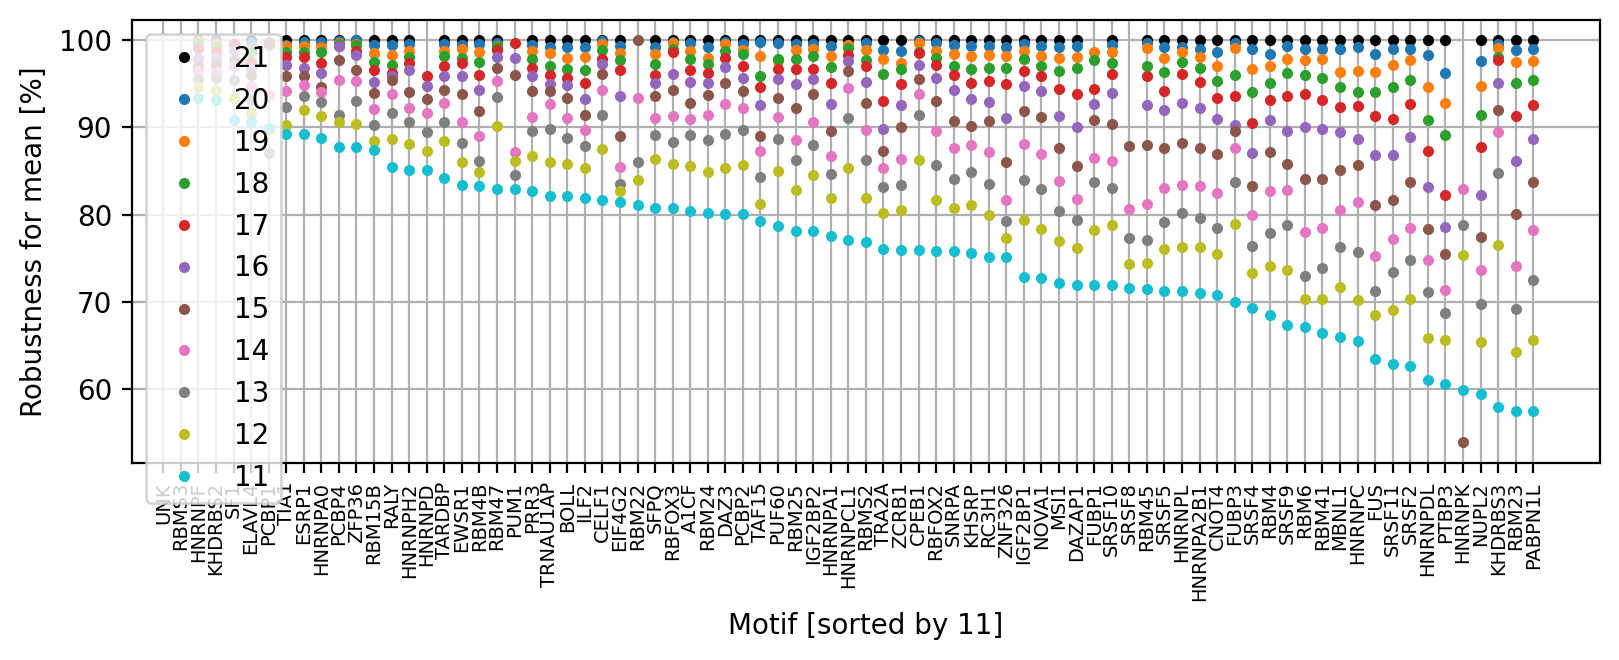

In [8]:
at_mean = results_genome["mean"].applymap(lambda x: x[0])
plot_motif_robustness(at_mean, 11, "Robustness for mean [%]")

In [9]:
result = np.zeros(at_mean.shape[0], np.int) + 21
for col in sorted(at_mean, reverse=True):
    result[at_mean[col] > 0.9] = col
result[result % 2 == 0] += 1

/tmp/ipykernel_3746474/1225785732.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result = np.zeros(at_mean.shape[0], np.int) + 21


In [10]:
with open("../data/am_1-to-3-motif_widths_above_90_shorter_donor.json", "w") as f:
    json.dump(result.tolist(), f)

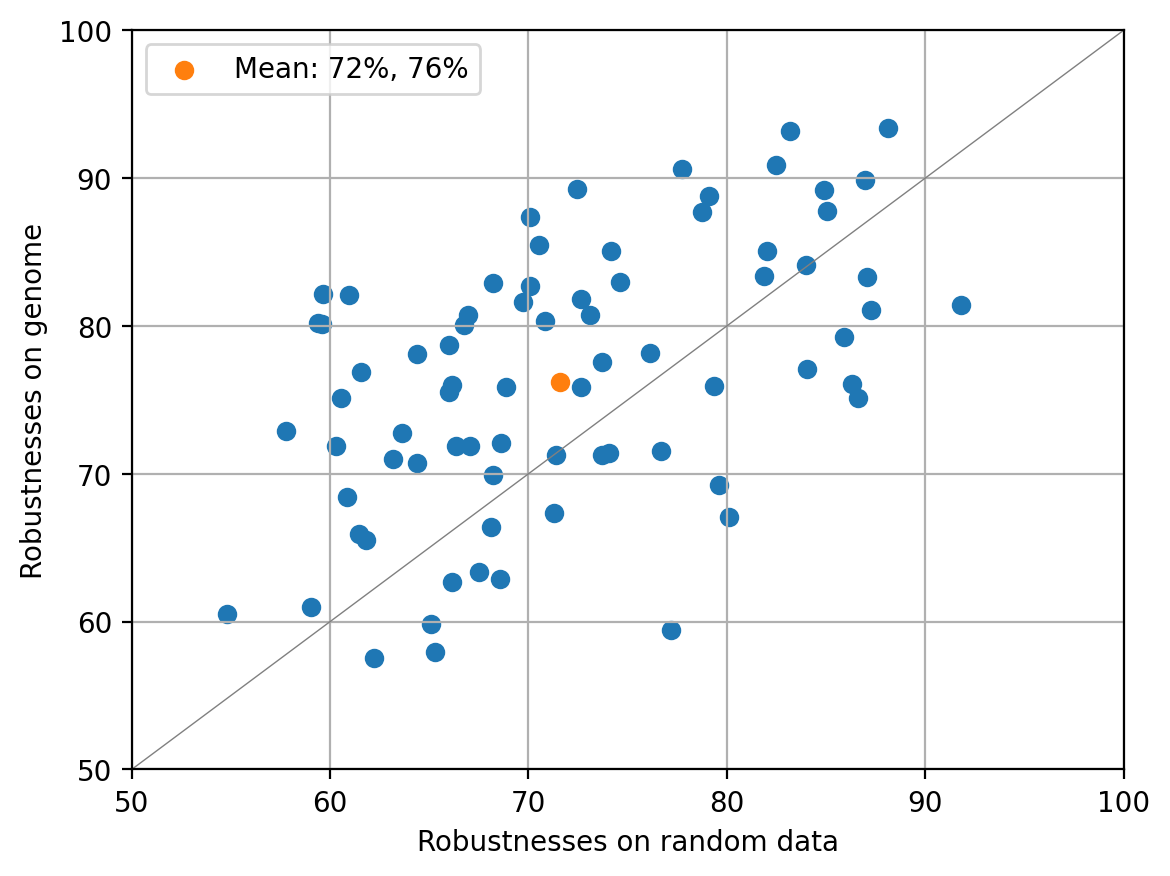

In [11]:
plt.figure(dpi=200, facecolor="white")
xs, ys = (
    100 * results_random["mean"][11].apply(lambda x: x[0]),
    100 * results_genome["mean"][11].apply(lambda x: x[0]),
)
plt.scatter(xs, ys)
plt.scatter(xs.mean(), ys.mean(), label=f"Mean: {xs.mean():.0f}%, {ys.mean():.0f}%")
plt.xlabel("Robustnesses on random data")
plt.ylabel("Robustnesses on genome")
plt.plot([50, 100], [50, 100], color="gray", linewidth=0.5)
plt.xlim(50, 100)
plt.ylim(50, 100)
plt.grid()
plt.legend()
plt.show()

In [12]:
rbps = pd.read_csv("../data/rbd_count.csv").set_index("RBP")
metrics = at_11.copy()
metrics["no_rbps"] = np.array(
    [np.array(rbps.loc[x])[0] if x in rbps.index else np.nan for x in metrics.index]
)

/tmp/ipykernel_3746474/4076957237.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  metrics["no_rbps"] = np.array(


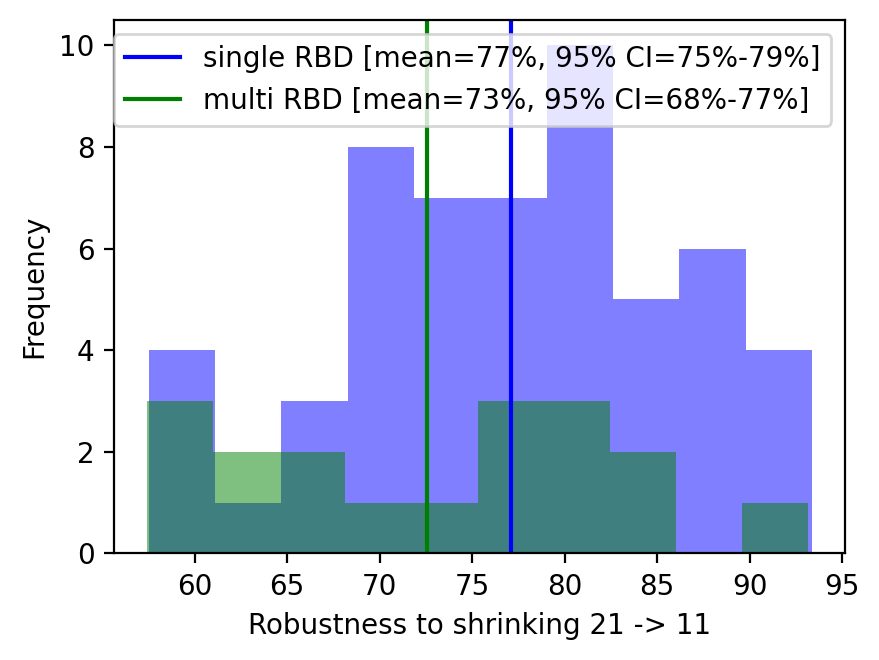

In [13]:
def plot_with_mask(name, color, mask):
    items = np.array(metrics["mean"][mask] * 100)
    items = items[np.isfinite(items)]
    plt.hist(items, color=color, alpha=0.5)
    mu = items.mean()
    lo, hi = bootstrap(np.array(items))
    plt.axvline(
        mu, label=f"{name} [mean={mu:.0f}%, 95% CI={lo:.0f}%-{hi:.0f}%]", color=color
    )


plt.figure(figsize=(4.5, 3.4), dpi=200, facecolor="white", tight_layout=True)
plot_with_mask("single RBD", "blue", metrics.no_rbps > 1)
plot_with_mask("multi RBD", "green", metrics.no_rbps == 1)
plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Robustness to shrinking 21 -> 11")
plt.show()

In [14]:
exact_motif_table = np.mean(
    [nearest_neighbor_motifs_differences_table(models[k], 1000, 100) for k in models],
    axis=0,
)
stats = {
    "Mean Distance to Nearest Motif": np.mean(
        [nearest_neigboring_motifs_distances(models[k], 1000) for k in models], axis=0
    ),
    "% of closest motifs between 7-10 away": exact_motif_table[7 : 10 + 1].sum(0)
    / exact_motif_table.sum(0)
    * 100,
}

/mnt/md0/ExpeditionsCommon/spliceai/Canonical/modular_splicing/width_experiments/distance_between_motifs.py:96: RuntimeWarning: invalid value encountered in divide
  return sums / counts


TypeError: 'module' object is not callable

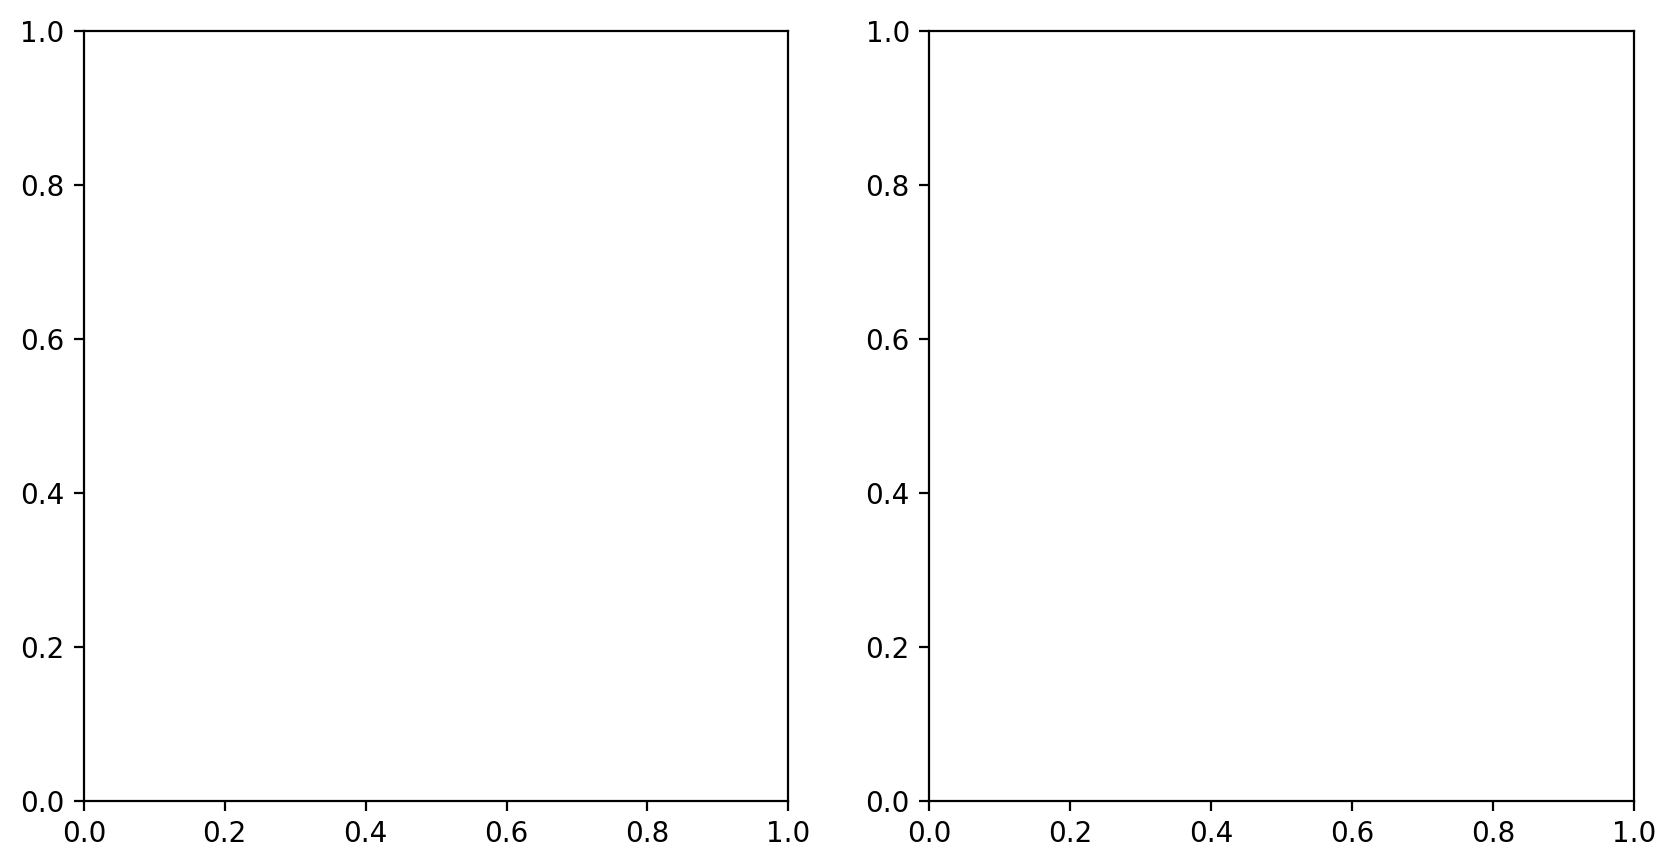

In [15]:
_, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
for k, ax in zip(stats, axs):
    regress(
        k,
        stats[k],
        metrics["mean"] * 100,
        ax,
        scatter_kwargs={},
    )
    ax.set_ylabel("Motif robustness")
    ax.grid()
plt.show()

In [ ]:
from modular_splicing.width_experiments.lang_rbp_complex import (
    load_interactions,
    robustness_analysis,
    universal_set,
)

In [ ]:
load_interactions()["premRNP_formation"]

In [ ]:
table, mu = robustness_analysis(metrics["mean"])

In [ ]:
(table * 100).round(1)

In [ ]:
mu